In [1]:
import json
import re
import pandas as pd
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_colwidth', None)

from transformers import AutoTokenizer
from tqdm import tqdm
from nltk import sent_tokenize
from collections import defaultdict

from prompts import prospect_lm_v2_system_message

In [2]:
llama_tokenizer = AutoTokenizer.from_pretrained(
        "meta-llama/Llama-2-7b-hf",
        model_max_length=2048,
        padding_side="right",
        use_fast=False,
)

def llama_seq_len(text):
    return len(llama_tokenizer(text)['input_ids']) + 6

In [121]:
# segment_topic_pairs = []
# for call in new_calls:
#     for segment in call['segments']:
#         segment_topic_pairs.append((segment['text'], segment['topics']))

# segment_topic_df = pd.DataFrame(segment_topic_pairs, columns=['text', 'topics'])

In [122]:
with open('/Users/andrew/dev/FastChat-Cue/preprocess/data/enriched_domains_with_empty_values_filled.json', "r") as f:
    enriched_domains = json.load(f)

domain_dict = {record['domain']: record for record in enriched_domains}

In [123]:
# category_line_map = {
#     "Lifecycle Marketing": "They want to use Hightouch to make their lifecycle marketing more effective.",
#     "Performance Marketing": "They want to use Hightouch to make their performance marketing more effective.",
#     "B2B SaaS (PLG)": "They want to use Hightouch to give more insights and lead prioritization to their sales team.",
#     "CDP Compete": "They are evaluating Hightouch versus traditional CDPs like Segment, MParticle, and Simon Data.",
#     "Census Compete": "They are evaluating Hightouch versus other Reverse ETL providers like Census.",
#     "LiveRamp Compete": "They are evaluating Hightouch versus other data enrichment and ad performance boosting solutions like LiveRamp."
# }    

In [124]:
with open("/Users/andrew/dev/account-research/speech_to_text/data/intro_detailed_calls.json", "r") as f:
    raw_data = json.load(f)

id_to_raw_call = {call['metaData']['id']: call for call in raw_data}

In [3]:
def clean_text(text):
    text_hightouch = re.sub(r"hi(gh)?(\s|-)?(touch|tech|treasure|tax|test|tips|tension|towers|tex)", "Hightouch", text, flags=re.IGNORECASE)
    return text_hightouch.strip()


def normalize_industry(industry):
    if not industry:
        return None
    return industry.lower().replace('&', 'and').strip()


def get_info_record(company_info):
    info_record = {}
    for elem in company_info:
        if elem['name'] == "Name" and elem['name'] in info_record:
            curr_name = info_record[elem['name']]
            new_name = elem['value']
            if new_name and curr_name and len(new_name) < len(curr_name):
                info_record[elem['name']] = new_name
        else:
            info_record[elem['name']] = elem['value']

    if 'Website' in info_record and info_record['Website'] in domain_dict:
        info_record['domain'] = info_record['Website']
        source_record = domain_dict[info_record['Website']]
        if 'description' in source_record:
            info_record['description'] = source_record['description']
        elif 'organization' in source_record and 'short_description' in source_record['organization']:
            info_record['description'] = source_record['organization']['short_description']

        if 'Industry' not in info_record:
            if 'category' in source_record:
                info_record['Industry'] = source_record['category']['industry']
            elif 'organization' in source_record:
                info_record['Industry'] = source_record['organization']['industry']
    
    for key in ['Industry', 'description', 'domain', 'NumberOfEmployees']:
        if key not in info_record:
            info_record[key] = None

    if info_record['description'] and info_record['description'].strip().endswith('...'):
        description_sents = sent_tokenize(info_record['description'])
        new_desc = " ".join(description_sents[:-1])
        info_record['description'] = new_desc

    if info_record['description']:
        info_record['description'] = info_record['description'].split('\n\n')[0].strip()

    filtered_record = {
        "name": info_record['Name'],
        "industry": normalize_industry(info_record['Industry']),
        "description": clean_description(info_record['description']),
        "domain": info_record['domain'],
        "number_of_employees": info_record['NumberOfEmployees'],
    }

    return filtered_record


def clean_description(description, max_desc_len=80, margin=10):
    if not description:
        return description
    description = description.strip()
    if description.endswith('...'):
        description_sents = sent_tokenize(description)
        description = " ".join(description_sents[:-1])

    description = description.split('\n\n')[0].strip()
    if llama_seq_len(description) > max_desc_len:
        description_sents = sent_tokenize(description)
        total_len = 0
        new_sents = []
        for sent in description_sents:
            sent_len = llama_seq_len(sent)
            if total_len + sent_len <= max_desc_len + margin:
                new_sents.append(sent)
                total_len += sent_len
            else:
                break
        description = " ".join(new_sents)

    if len(description) == 0:
        description = None
    return description



def get_system_message_v1(company_info, categories):
    category_lines = "\n".join(['- ' + category_line_map[category] for category in categories if category in category_line_map])
    industry_starts_with_vowel = company_info['industry'] and company_info['industry'][0].lower() in ['a', 'e', 'i', 'o', 'u']
    system_message = f"A sales call between a sales representative at Hightouch, a data integration company, and a prospect at {company_info['name']}, a{'n' if industry_starts_with_vowel else ''} {company_info['industry'].lower() + ' ' if company_info['industry'] else ''}company. Hightouch helps companies get data into business tools. The prospect's goal is to understand how Hightouch compares to their current solution for syncing data into business tools and how Hightouch can deliver value for the prospect's business. The prospect answers any questions that the sales rep asks them. The prospect also asks questions to the sales rep in order to learn more about Hightouch and how it can help the prospect's business."
    cleaned_description = clean_description(company_info['description'])
    if cleaned_description:
        system_message += f"\n\nHere is a description of {company_info['name']}:\n{cleaned_description}"
    if len(category_lines) > 0:
        system_message += f"\n\nHere is some additional information about how {company_info['name']} is considering to use Hightouch:\n{category_lines}"
    return system_message.strip()


def get_example_from_call(call):
    call_id = call['metadata']['id']
    conversations = []
    bad_topics = set(['Small Talk', 'Wrap-Up', 'Next Steps - Scheduliing'])
    sales_rep_count = defaultdict(lambda: 0)
    prospect_count = defaultdict(lambda: 0)
    for segment in call['segments']:
        segment_topics = set(segment['topics'])
        segment_text_cleaned = clean_text(segment['text'])
        if (len(segment_topics) == 0 or (not segment_topics.issubset(bad_topics))) and len(segment_text_cleaned) > 0:
            speaker = "sales rep" if segment['speakerAffiliation'] == "Internal" else "prospect"
            if len(conversations) > 0 and conversations[-1]['from'] == speaker:
                conversations[-1]['value'] += " " + segment_text_cleaned
            else:
                conversations.append({
                    "from": speaker,
                    "value": segment_text_cleaned,
                    "topic": list(segment_topics),
                })
                if speaker == "sales rep":
                    sales_rep_count[segment['speakerId']] += 1
                else:
                    prospect_count[segment['speakerId']] += 1
    
    if len(conversations) < 2:
        return None
        
    # if len(sales_rep_count.items()) == 0 or len(prospect_count.items()) == 0:
    #     print(call_id)
    #     print(conversations)
    sales_rep_id = max([(k, v) for k, v in sales_rep_count.items()], key=lambda x: x[1])[0]
    prospect_id = max([(k, v) for k, v in prospect_count.items()], key=lambda x: x[1])[0]

    raw_call = id_to_raw_call[call_id]
    sales_rep_party = [party for party in raw_call['parties'] if party['speakerId'] == sales_rep_id][0]
    prospect_party = [party for party in raw_call['parties'] if party['speakerId'] == prospect_id][0]

    info_record = get_info_record(call['company_info'])
    output = {
        "id": call_id,
        "title": call['metadata']['title'],
        "speaker_info": {
            "sales_rep": {
                "name": sales_rep_party['name'],
                "title": sales_rep_party['title'] if 'title' in sales_rep_party else None
            },
            "prospect": {
                "name": prospect_party['name'],
                "title": prospect_party['title'] if 'title' in prospect_party else None
            },
        },
        "company_info": info_record,
        "conversations": conversations
    }
    return output 

In [130]:
with open("/Users/andrew/dev/account-research/speech_to_text/data/intro_calls_retranscribed_v2.json", "r") as f:
    new_calls = json.load(f)

len(new_calls)

424

In [131]:
dataset = [get_example_from_call(call) for call in new_calls]
print(len(dataset))
dataset = [example for example in dataset if example]
print(len(dataset))

424
408


In [132]:
total_segments = 0
for call in dataset:
    total_segments += len(call['conversations'])

total_segments

23385

In [133]:
with open("/Users/andrew/dev/FastChat-Cue/data/prospect_lm/prospect_calls_hightouch_v2.json", "w+") as f:
    json.dump(dataset, f)

In [134]:
prospect_titles = [call['speaker_info']['prospect']['title'] for call in dataset]

In [135]:
len(prospect_titles)

408

In [136]:
len([title for title in prospect_titles if title])

262

In [9]:
def get_company_size(num_employees):
    if not num_employees:
        return None
        
    range_starts = [1, 2, 51, 251, 501, 1001, 10001]
    classes = ["Solo Entrepreneur", "Small Business", "Medium-sized Business", "Large Business", "Very Large Business", "Major Corporation", "Mega Corporation"]
    idx = 0
    while idx < len(range_starts) and num_employees > range_starts[idx]:
        idx += 1
    return classes[idx-1].lower()


def get_system_message_v2(call):
    company_info = call['company_info']
    
    if company_info['industry']:
        industry_starts_with_vowel = company_info['industry'][0].lower() in ['a', 'e', 'i', 'o', 'u']
        company_appositive = f", a{'n' if industry_starts_with_vowel else ''} {company_info['industry'].lower() + ' '}company"
    else:
        company_appositive = ""

    prospect_title = call['speaker_info']['prospect']['title']
    if prospect_title:
        prospect_position_sentence = f"The prospect's position at {company_info['name']} is {prospect_title}."
    else:
        prospect_position_sentence = ""

    formatted_prompt = prospect_lm_v2_system_message.format(
        company_name=company_info['name'],
        company_appositive=company_appositive,
        sales_rep_name=call['speaker_info']['sales_rep']['name'],
        prospect_name=call['speaker_info']['prospect']['name'],
        prospect_position_sentence=prospect_position_sentence,
        company_industry=company_info['industry'],
        company_size=get_company_size(company_info['number_of_employees']),
        company_description=company_info['description'],
        scenario=call['scenario']
    )
    return formatted_prompt

In [5]:
with open("/Users/andrew/dev/FastChat-Cue/preprocess/data/train/prospect_calls_hightouch_v2.json", "r") as f:
    dataset = json.load(f)

with open("/Users/andrew/dev/FastChat-Cue/preprocess/data/scenarios/v2/prospect_calls_hightouch_v2_extracted_scenarios_call_id.json") as f:
    scenario_dict = json.load(f)

for call in dataset:
    call['scenario'] = scenario_dict[call['id']]

In [140]:
len(dataset), len(scenario_dict)

(408, 408)

In [10]:
def get_example_from_call_v2(call):
    record = {
        "id": call['id'],
        "system_message": get_system_message_v2(call),
        "conversations": call['conversations']
    }
    return record

In [11]:
train_examples = [get_example_from_call_v2(call) for call in dataset]    

In [12]:
print(train_examples[0]['system_message'])

The following is a transcript of an introductory sales call between a sales representative at Hightouch, a data integration company, and a prospect at Saras Analytics, an internet software and services company. The sales rep at Hightouch is John Alderman, and the prospect at Saras Analytics is Ashraf. 

Hightouch overview:
CDPs are used to help companies get data into their business tools like their marketing tools to run more targeted and effective campaigns. Hightouch provides a Composable CDP solution by helping companies leverage the data in their data warehouse for marketing campaigns. Hightouch syncs data from warehouses directly into SaaS tools to enable personalized marketing, sales and support experiences. It is different from a traditional CDP like Segment because traditional CDPs are less flexible.

Saras Analytics information:
Industry: internet software and services
Size: medium-sized business
Description: Saras Analytics is a data management company that aids in growth by

In [26]:
system_message_lens = [llama_seq_len(example['system_message']) for example in train_examples]

<Axes: ylabel='Frequency'>

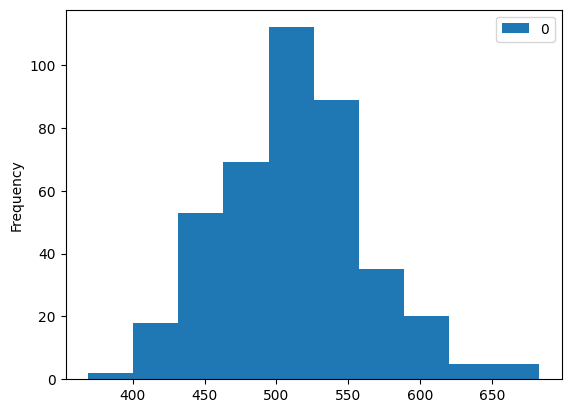

In [27]:
pd.DataFrame(system_message_lens).plot.hist()

In [15]:
scenarios = list(scenario_dict.values())

In [22]:
scenario = scenarios[0]
competitions = [re.search(r"Competition:[\s\S]+", scenario).group(0) for scenario in scenarios]


In [25]:
pd.DataFrame(competitions).sample(50)

,0
36,Competition: The prospect is considering Snowflake as an alternative to BigQuery and is using Google Sheets as their current solution for data manipulation.
357,Competition: There is no mention of any specific competitors to Hightouch that Zego is considering or currently using.
147,Competition:\n- No competitors mentioned in the transcript.
398,Competition: The prospect is considering other solutions like Supermetrics and Coefficient.
84,"Competition:\n- DoubleVerify has had conversations with Census, another reverse ETL solution similar to Hightouch. They are considering different options and evaluating how each solution can meet their needs."
181,"Competition: Fivetran is currently being used by Achievers, but they are open to exploring other options in the market, such as Hightouch."
305,Competition: \n- Sunstate Equipment is considering Salesforce and PipeDrive as potential CRMs to migrate to. They are looking for a solution that allows them to integrate with different best-in-class tools and avoid using extensions in CRM app stores. They are also interested in exploring other tools like Badger Maps for territory management and would prefer to integrate directly with these tools using Hightouch's generic destinations or by requesting additions to Hightouch's destination list.
7,Competition:\n- Clearbit is mentioned as a competitor to Hightouch for the company's current use case of offline conversions and audience building.
202,"Competition:\n- The prospect mentions potential competitors or tools they may consider using in the future, such as Salesforce, Intercom, and other customer support tools. They also mention using custom integrations with tools like Twilio and SendGrid."
256,Competition: No specific competitors were mentioned in the transcript.


In [28]:
null_ids = [call['id'] for call in dataset if not call['company_info']['description']]

In [29]:
null_ids

['3126725447696250703',
 '4913910317801999717',
 '2559383333213060406',
 '6585715818623855062',
 '749322851037989751',
 '610668421683570630',
 '3687633569981849561',
 '8707099994091951802',
 '587722167310194375',
 '7935081203646290251',
 '8113927756661462575',
 '496357154379990524',
 '5702548714993633943',
 '8267542907278197033',
 '9110254699274951099',
 '5876250805141239371',
 '5931359696662304422',
 '344857589829852788',
 '8572115626689051757',
 '7713591824053606767',
 '8078521062475391944',
 '5471152051700408355',
 '8881574695326731014']

In [30]:
example_id_map = {example['id']: example for example in train_examples}

In [35]:
with open("/Users/andrew/dev/FastChat-Cue/data/prospect_lm/prospect_lm_v2_train_full_length.json", "w") as f:
    json.dump(train_examples, f)

In [38]:
import os
data_dir = "/Users/andrew/dev/FastChat-Cue/data/prospect_lm"
for filename in os.listdir(data_dir):
    full_path = os.path.join(data_dir, filename)
    with open(full_path, "r") as f:
        data = json.load(f)
    # for example in data:
    #     for turn in example['conversations']:
    #         del turn['topic']
    with open(full_path, "w") as f:
        json.dump(data, f, indent=4)
    print(filename)

prospect_lm_v2_train_split_max_2500.json
prospect_lm_v2_train_full_length.json
prospect_lm_v2_train_split_max_3000.json
prospect_lm_v2_train_split_max_2000.json


In [34]:
print(example_id_map[null_ids[2]]['system_message'])

The following is a transcript of an introductory sales call between a sales representative at Hightouch, a data integration company, and a prospect at sideview.media. The sales rep at Hightouch is John Alderman, and the prospect at sideview.media is Elijah Gray. 

Hightouch overview:
CDPs are used to help companies get data into their business tools like their marketing tools to run more targeted and effective campaigns. Hightouch provides a Composable CDP solution by helping companies leverage the data in their data warehouse for marketing campaigns. Hightouch syncs data from warehouses directly into SaaS tools to enable personalized marketing, sales and support experiences. It is different from a traditional CDP like Segment because traditional CDPs are less flexible.

sideview.media information:
Industry: None
Size: None
Description: None

Key points from transcript:
Use case: 
- The prospect, sideview.media, is a queer marketplace that started due to COVID. They have a database in 